<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/brandon_ver/Machine_Learning(remove_less_chosen_hobbies).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
%cd /content
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from skmultilearn.ensemble import * 
from skmultilearn.cluster import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import time

# random seed
seed = 0

/content
Cloning into 'Self_Love_App'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 117 (delta 66), reused 23 (delta 11), pack-reused 0
Receiving objects: 100% (117/117), 864.23 KiB | 13.29 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/Self_Love_App
     |████████████████████████████████| 92kB 2.9MB/s 


# Data Preparation

In [2]:
def data_normalization(df):
  # explicity min max scale because we already know the range is from 5 to 1
  df.iloc[:,50:64] = df.iloc[:,50:64].apply(lambda x: (x-1)/(5-1)) 
  return df

In [43]:
def filter_hobbies(df_norm):
  x = df_norm.iloc[:, :64]
  y = df_norm.iloc[:, 64:]
  distribution_of_hobbies = y.sum()
  y = y[distribution_of_hobbies[distribution_of_hobbies>9].index] # remove the hobbies that are least selected by the people
  # only select the examples that have at least 1 hobby chosen
  filtered_index = y.sum(axis=1) > 0
  x  = x[filtered_index]
  y  = y[filtered_index]
  return pd.concat([x, y], axis =1), filtered_index

In [65]:
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df = data_cleaning(df)
df = data_encoding(df)
df_norm = data_normalization(df)
df_norm, filtered_index = filter_hobbies(df_norm)
df_norm

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?,Badminton,Playing computer games,Playing board games,Reading,Team sports,Exercising,Writing,Dancing,Gardening,Painting,Cooking,Singing,Puzzles,Collecting
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00,0.0,0.0,1.0,1.

In [66]:
x = df_norm.iloc[:, :64]
y = df_norm.iloc[:, 64:] 

x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 149
Number of test dataset: 38


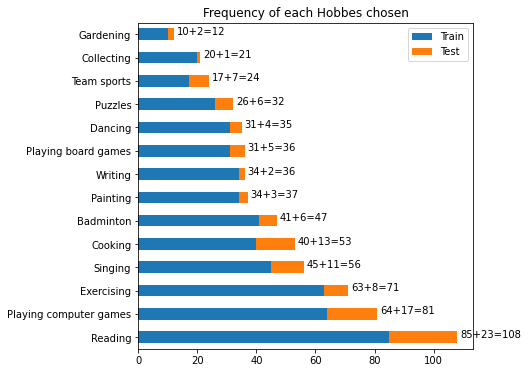

In [67]:
# draw the distribution of the hobbies with a horizontal bar chart
distribution_of_hobbies = y.sum().sort_values(ascending=False)
distribution_of_hobbies_train_test = pd.DataFrame(np.concatenate([y_train.sum(axis=0)[:,None], y_test.sum(axis=0)[:,None]], axis=1), index=y.columns, columns=["Train","Test"])
distribution_of_hobbies_train_test = distribution_of_hobbies_train_test.reindex(distribution_of_hobbies.index)
distribution_of_hobbies_train_test.plot(kind='barh', figsize=(6, 6), title="Frequency of each Hobbes chosen", stacked=True)

# put the frequency text on the right of the bar chart
for i, (row_index, row) in enumerate(distribution_of_hobbies_train_test.iterrows()):
  train_value = row["Train"]
  test_value = row["Test"]
  sum_value = train_value + test_value
  plt.text(x=sum_value+1 , y =i , s=f"{int(train_value)}+{int(test_value)}={int(sum_value)}" , fontdict=dict(fontsize=10))

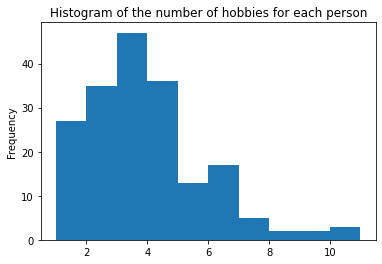

In [48]:
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

# Models

In [49]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision_Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Tree", ExtraTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120,10),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("Random_Forest", RandomForestClassifier) :{'n_estimators':range(90,120,10),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1], 'max_iter': [2000],'random_state':[seed]},
    ("Ridge", RidgeClassifierCV) : {'fit_intercept':[True]}
}

base_models_with_errors = {
    # Error: No neighbors found for test samples array (need to increase the radius size to 20, only can run)
    ("Radius_Neighbours", RadiusNeighborsClassifier) : {'radius':[1.0,1.5,2.0],'leaf_size':range(20,40),'p':range(1,3)},
}

# Adaptation approaches
adapt_models = {
    ("Binary_Relevance_kNN_A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary_Relevance_kNN_B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label_KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM_Neural_Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin_SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary_Relevance" : BinaryRelevance,
    "Classifier_Chain" : ClassifierChain,
    # "Label_Powerset" : LabelPowerset # too many output because 2^20 = 1048576
}

# Ensembles of Classifiers
emsemble_methods = {
    "Distinct_Random k-labtest" : RakelD,
    "Overlapping_Random_k-labtest" : RakelO,
    "Label_Space_Partitoning" : LabelSpacePartitioningClassifier,
    "Majoity_Voting" : MajorityVotingClassifier
}
# Multi-label embeddings (KIV)

# Hyperparameters

In [50]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [72]:
results = {}
scoring = 'f1_micro'
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  clf = GridSearchCV(model(), params, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
  if model_name == "Twin_SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary_Relevance_kNN_A 0.39095576822970346
Binary_Relevance_kNN_B 0.21655124439301748
Multi-Label_KNN 0.39095576822970346
ARAM_Neural_Network 0.38460457513797175
Twin_SVM 0.4408900874610568


### Problem Transformation

In [73]:
scoring = 'f1_micro'
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
# Random forest and ExtraTrees takes about 20 minutes each, if dw to wait, can just comment out these 2 algo in the dict above
for strategy_name, strategy in problem_transform.items():
  for (model_name, model), params in base_models.items():
    parameters = {}
    for param_name, param_value in params.items():
      parameters["classifier__"+param_name] = param_value
    kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) 
    clf = GridSearchCV(strategy(classifier=model()), parameters, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
    clf.fit(x_train, y_train)
    results[f"{strategy_name}_{model_name}"] = clf
    print(f"{strategy_name}_{model_name}",clf.best_score_)

Binary_Relevance_Decision_Tree 0.35298281863387576
Binary_Relevance_Extra_Tree 0.3708144205421287
Binary_Relevance_Extra_Trees 0.37481854697672223
Binary_Relevance_Random_Forest 0.35340642298358904
Binary_Relevance_MLP 0.38293355687057334
Binary_Relevance_Ridge 0.34445300683628954
Classifier_Chain_Decision_Tree 0.3703377039133357
Classifier_Chain_Extra_Tree 0.3493237406591062
Classifier_Chain_Extra_Trees 0.37507088422002366
Classifier_Chain_Random_Forest 0.31919851044670056
Classifier_Chain_MLP 0.38595043379682925
Classifier_Chain_Ridge 0.32273738394418744


### Ensembles of Classifiers (Under reconstruction)

#### Adaptation approaches

In [ ]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = model()
    for param_name, param_value in params.items():
      paramter["classifier__"+param_name] = param_value
    parameters.append(parameter)

  return paramters

In [ ]:
scoring = 'f1_micro'
for emsemble_name, emsemble_method in emsemble_methods.items():
  for strategy_name, strategy in problem_transform.items():
    for base_model_name, base_model in base_models.items():
      kfold = KFold(n_splits=num_of_kfold_splits, random_state=seed)
      model = strategy(
              classifier = base_model(),
              require_dense = [False, True] # depens on the data is sparse or dense
      )
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring)
      results.append(cv_results)
      names.append(model_name)
      msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
      print(msg)
      classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

In [ ]:
classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)


# Evaluation 

In [53]:
def display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro"):
  result_table = []
  for model_name, model in results.items():
    y_pred = model.predict(x_test)
    score = f1_score(y_test, y_pred, average=f1_average)
    score_by_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    result_table.append([score]+score_by_class.tolist())

  # f1 score evaluation result overall and by class in percentage 
  # 0 means no True Positive at all or there is no example of that class in the y_text at all
  result_table_df = pd.DataFrame(result_table, columns=["Overall"]+y.columns.tolist(), index=results.keys()) * 100
  result_table_df.sort_values(by='Overall', inplace=True, ascending=False)

  # arrange the columns according to the frequency of each hobbies in the test set
  sorted_columns = distribution_of_hobbies_train_test["Test"].sort_values(ascending=False).index.tolist()
  modified_column_names = [column + "(" + str(int(distribution_of_hobbies_train_test.loc[column,"Test"]))+")" for column in sorted_columns]
  result_table_df = result_table_df[["Overall"] + sorted_columns] # sort the columns by the frequency of each hobbies in the test set 
  result_table_df.columns = [["Overall"] + modified_column_names] # add the frequency of each hobbies in the test set in the column name
  return result_table_df

In [54]:
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Reading(23),Playing computer games(17),Cooking(13),Singing(11),Exercising(8),Team sports(7),Puzzles(6),Badminton(6),Playing board games(5),Dancing(4),Painting(3),Gardening(2),Writing(2),Collecting(1)
Binary_Relevance_MLP,42.857143,59.574468,50.000000,66.666667,35.294118,34.782609,36.363636,18.181818,25.000000,36.363636,28.571429,22.222222,0.000000,28.571429,0.000000
Classifier_Chain_Extra_Trees,38.150289,70.588235,46.666667,26.666667,30.769231,36.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Twin_SVM,35.750422,75.409836,61.818182,50.980392,44.897959,34.782609,45.161290,28.571429,27.272727,25.000000,19.512195,10.526316,9.523810,10.000000,5.882353
Classifier_Chain_MLP,35.185185,50.000000,48.648649,47.619048,25.000000,35.714286,36.363636,0.000000,25.000000,18.181818,0.000000,25.000000,0.000000,33.333333,0.000000
Binary_Relevance_Decision_Tree,34.944238,72.000000,41.176471,35.714286,46.153846,40.000000,20.000000,26.666667,10.526316,13.333333,0.000000,0.000000,22.222222,0.000000,0.000000
ARAM_Neural_Network,34.545455,63.636364,37.500000,36.363636,46.153846,54.545455,0.000000,18.181818,13.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Binary_Relevance_Extra_Tree,34.241245,60.000000,43.243243,45.454545,47.619048,26.086957,33.333333,46.153846,9.090909,18.181818,0.000000,0.000000,0.000000,14.285714,0.000000
Classifier_Chain_Decision_Tree,34.220532,61.224490,43.243243,33.333333,41.666667,29.629630,20.000000,28.571429,10.526316,30.769231,0.000000,0.000000,25.000000,16.666667,0.000000
Binary_Relevance_Extra_Trees,34.117647,63.829787,50.000000,26.666667,0.000000,34.782609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Binary_Relevance_Ridge,33.879781,66.666667,52.631579,33.333333,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Outlier Removal

# Feature Selection

### Chi Square Analysis
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [55]:
def sort_by_questions(data, x, ascending = False):
  question_answers_score = pd.DataFrame(data, index=x.columns).reset_index()
  question_answers_score["Question"] = question_answers_score["index"].apply(lambda column_name : column_name.split("_")[0])
  question_score = question_answers_score.groupby("Question").mean().sort_values(0, ascending=ascending)
  return question_score

def select_best_k_features(df, k=None, thres_value=None, more_than_thres_value = True ):
  if k:
    # choose the k best feature by explicitly stating the length
    best_k_features = df.index[:k].tolist()
  elif thres_value:
    # choose the k best feature by certain threshold
    if more_than_thres_value:
      best_k_features = df[df[0] > thres_value].index.tolist()
    else:
      best_k_features = df[df[0] < thres_value].index.tolist()
  
  return best_k_features

def label_encoding(data_source):
  df = pd.read_csv(data_source)
  df = df.iloc[2:,:].reset_index(drop=True) # delete first 2 responses
  df1 = df.iloc[:, 1:3]
  df2 = df.iloc[:, 18:]
  df_ranges = df.iloc[:, 4:18]
  df_categories = pd.concat([df1, df2], axis =1)
  df_categories_encoder = df_categories.apply(LabelEncoder().fit_transform)
  return pd.concat([df_categories_encoder, df_ranges], axis =1)

label_encoding_df = label_encoding("WID3006 ML Questionnaire.csv")

# calculate the correlation score of each feature by class using chi-squared
selected_features = [] 
label_encoding_df = label_encoding_df[filtered_index]
x_train_label_encoded, _, y_train, _ = train_test_split(label_encoding_df.to_numpy(), y_numpy, test_size=0.2, random_state=seed)
for i in range(y_numpy.shape[1]):
    selector = SelectKBest(chi2, k='all')
    selector.fit(x_train_label_encoded, y_train[:,i])
    selected_features.append(list(selector.scores_))

# average all the class scores by feature  
selected_features = np.mean(selected_features, axis=0) 

chi2_analysis = pd.DataFrame(selected_features[:,None], index=label_encoding_df.columns).sort_values(0, ascending = False)
chi2_analysis


,0
Gender:,3.426719
How do you organize your thoughts? Please pick whichever is closest.,3.052265
Choose a pet which you prefer to keep.,1.408217
I prefer to spend my money on....,1.394394
What is your favorite color?,1.330150
"When you retire, you'd like to live...",1.164201
Do you enjoy socializing with large groups of people?,1.045551
What boosts your confidence ?,0.983950
Do you like to sit in front of a computer for long hours?,0.801735
What do you worry more about the most?,0.526888


##### Evaluation

In [57]:
params = adapt_models[("Twin_SVM", MLTSVM)]
# params = base_models[("MLP", MLPClassifier)]
# params = {"classifier__"+param_name:param for param_name, param in params.items()}
# params["classifier"] = [MLPClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(chi2_analysis.index)):
  best_k_features = select_best_k_features(chi2_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  y_sparse = sparse.csr_matrix(y_train)
  x_sparse = sparse.csr_matrix(x_train)
  clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_sparse, y_sparse)
  # clf = GridSearchCV(ClassifierChain(), params, cv=5, n_jobs=-1, scoring=scoring)
  # clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.3375
Number of best k features: 2 score: 0.3181818181818182
Number of best k features: 3 score: 0.34468937875751504
Number of best k features: 4 score: 0.34782608695652173
Number of best k features: 5 score: 0.3595505617977528
Number of best k features: 6 score: 0.346938775510204
Number of best k features: 7 score: 0.3395225464190981
Number of best k features: 8 score: 0.38692098092643057
Number of best k features: 9 score: 0.3945205479452055
Number of best k features: 10 score: 0.37837837837837834
Number of best k features: 11 score: 0.3891625615763547
Number of best k features: 12 score: 0.3829787234042553
Number of best k features: 13 score: 0.34726688102893893
Number of best k features: 14 score: 0.34782608695652173
Number of best k features: 15 score: 0.34782608695652173
Number of best k features: 16 score: 0.35064935064935066
Number of best k features: 17 score: 0.35008103727714746
Number of best k features: 18 score: 0.3925729442970822
Numbe

- Twin SVM was used to test the model by adding the top feature at each iteration to determine the best number of features. 
- It was because Twin SVM is fast to train and always perform greatly on average (top1-top5).  
- The best number of features was 20.

In [64]:
# params = adapt_models[("Twin_SVM", MLTSVM)]
params = base_models[("MLP", MLPClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [MLPClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(chi2_analysis.index)):
  best_k_features = select_best_k_features(chi2_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  # y_sparse = sparse.csr_matrix(y_train)
  # x_sparse = sparse.csr_matrix(x_train)
  # clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  # clf.fit(x_sparse, y_sparse)
  clf = GridSearchCV(ClassifierChain(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.34517766497461927
Number of best k features: 2 score: 0.313953488372093
Number of best k features: 3 score: 0.34615384615384615
Number of best k features: 4 score: 0.3501945525291829
Number of best k features: 5 score: 0.3605150214592275
Number of best k features: 6 score: 0.37229437229437234
Number of best k features: 7 score: 0.375
Number of best k features: 8 score: 0.38961038961038963
Number of best k features: 9 score: 0.3964757709251101
Number of best k features: 10 score: 0.4403669724770642
Number of best k features: 11 score: 0.38235294117647056
Number of best k features: 12 score: 0.3402061855670103
Number of best k features: 13 score: 0.35000000000000003
Number of best k features: 14 score: 0.33497536945812806
Number of best k features: 15 score: 0.3838383838383838
Number of best k features: 16 score: 0.31
Number of best k features: 17 score: 0.34313725490196073
Number of best k features: 18 score: 0.38647342995169076
Number of best k fea

- With all the features used to train, **Binary_Relevance_MLP** beats all the other algorithms. However, when 20 features was used, its performance got degraded as below.
- In order to find a better number of features, I searched for the best number of features by training **Binary_Relevance_MLP** on various number of features as above.
- In conclusion, I think **MLP** is not reproducible since many random states involved.

In [60]:
def filter_features(best_k_features, df_norm):
  return df_norm[ [column_name 
                    for column_name in df_norm.columns 
                    for question in best_k_features 
                    if column_name.startswith(question)]]

# the best number of features is 20
best_k_features = select_best_k_features(chi2_analysis, k=20)
x = filter_features(best_k_features, df_norm)
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
best_k_features

['Gender: ',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'Choose a pet which you prefer to keep.',
 'I prefer to spend my money on....',
 'What is your favorite color?',
 "When you retire, you'd like to live...",
 'Do you enjoy socializing with large groups of people?',
 'What boosts your confidence ? ',
 'Do you like to sit in front of a computer for long hours?',
 'What do you worry more about the most?',
 'Are you a perfectionist?',
 'What is your learning style? (Pick one that benefit you the most)',
 'Do you enjoy challenges?',
 'How creative of a person do you think you are?',
 'Do you have lot of patience?',
 'Do you enjoy making others happy?',
 'Would you rather visit the future or the past?',
 'Are you a trusting person?',
 'How logical of a person do you think you are?',
 "Can you understand others' perspectives and feelings?"]

- These 20 questions above were used to train all the algorithms.
- The results are shown below.

In [63]:
# the best 20 features was used to train all the algorithms
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Reading(23),Playing computer games(17),Cooking(13),Singing(11),Exercising(8),Team sports(7),Puzzles(6),Badminton(6),Playing board games(5),Dancing(4),Painting(3),Gardening(2),Writing(2),Collecting(1)
Twin_SVM,39.893617,66.666667,68.085106,54.054054,27.586207,32.432432,42.105263,41.666667,12.903226,32.000000,33.333333,13.333333,0.0,19.047619,0.000000
Classifier_Chain_MLP,39.408867,70.000000,58.823529,40.000000,23.529412,25.000000,40.000000,18.181818,25.000000,25.000000,0.000000,0.000000,0.0,40.000000,0.000000
Binary_Relevance_Decision_Tree,38.961039,66.666667,68.571429,33.333333,47.619048,38.461538,40.000000,16.666667,10.526316,0.000000,18.181818,0.000000,0.0,25.000000,0.000000
Classifier_Chain_Decision_Tree,38.888889,63.636364,64.864865,28.571429,50.000000,32.258065,33.333333,30.769231,10.526316,21.052632,25.000000,0.000000,0.0,22.222222,0.000000
Binary_Relevance_Random_Forest,35.928144,65.217391,64.705882,26.666667,0.000000,19.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Binary_Relevance_MLP,35.779817,68.292683,54.545455,36.363636,38.095238,32.000000,0.000000,0.000000,26.666667,16.666667,0.000000,22.222222,0.0,0.000000,0.000000
Classifier_Chain_Ridge,35.714286,76.595745,45.161290,23.529412,0.000000,23.529412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,50.000000,0.000000
Binary_Relevance_Extra_Trees,35.502959,69.565217,56.250000,0.000000,30.769231,26.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Classifier_Chain_Random_Forest,35.443038,75.555556,50.000000,0.000000,16.666667,22.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Binary_Relevance_Ridge,35.428571,68.181818,55.555556,37.500000,0.000000,17.391304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,50.000000,0.000000


### Recursive Feature Elimination (rfe)
https://machinelearningmastery.com/rfe-feature-selection-in-python/

Badminton 4
1 Gender: _Male
50 What is your learning style? (Pick one that benefit you the most)_By reading an e-Book
57 Are you a perfectionist?
62 Do you enjoy making others happy?


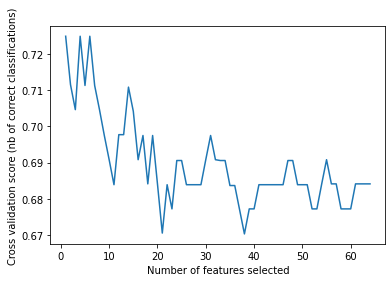

Playing computer games 41
1 Gender: _Male
4 What is your current occupation?_University student
5 What boosts your confidence ? _By leading others to success
7 What boosts your confidence ? _When someone acknowledges you
11 I prefer to spend my money on...._The latest fashion
12 I prefer to spend my money on...._The latest technology
13 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
14 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
18 Choose a pet which you prefer to keep._Dog
21 Choose a pet which you prefer to keep._Horse
22 Choose a pet which you prefer to keep._I'm not a pet person
23 Choose a pet which you prefer to keep._Rabbit
24 Choose a pet which you prefer to keep._Snake
25 Ch

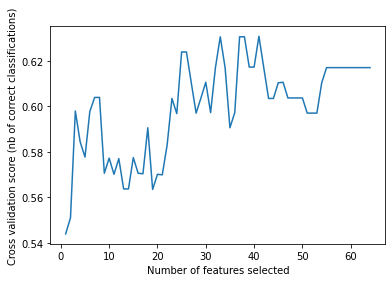

Playing board games 11
4 What is your current occupation?_University student
6 What boosts your confidence ? _Get the most/ special attention among the members
11 I prefer to spend my money on...._The latest fashion
12 I prefer to spend my money on...._The latest technology
17 Choose a pet which you prefer to keep._Cat
18 Choose a pet which you prefer to keep._Dog
19 Choose a pet which you prefer to keep._Fish
42 What is your favorite color?_Purple
48 What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions
57 Are you a perfectionist?
63 Can you understand others' perspectives and feelings?


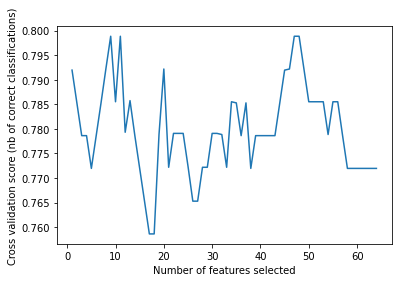

Reading 37
1 Gender: _Male
6 What boosts your confidence ? _Get the most/ special attention among the members
7 What boosts your confidence ? _When someone acknowledges you
8 What boosts your confidence ? _When you accomplish a project
11 I prefer to spend my money on...._The latest fashion
13 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
14 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
17 Choose a pet which you prefer to keep._Cat
21 Choose a pet which you prefer to keep._Horse
23 Choose a pet which you prefer to keep._Rabbit
24 Choose a pet which you prefer to keep._Snake
25 Choose a pet which you prefer to keep._Tortoise
27 What is your favorite time of the day?_Morning
28 What is 

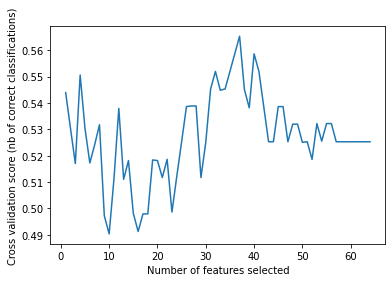

Team sports 24
1 Gender: _Male
7 What boosts your confidence ? _When someone acknowledges you
10 I prefer to spend my money on...._Home Improvements
12 I prefer to spend my money on...._The latest technology
14 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
18 Choose a pet which you prefer to keep._Dog
23 Choose a pet which you prefer to keep._Rabbit
26 What is your favorite time of the day?_Evening
27 What is your favorite time of the day?_Morning
28 What is your favorite time of the day?_Night
29 Would you rather visit the future or the past?_The future
32 What do you worry more about the most?_The state of the world
33 What do you worry more about the most?_Your family and friends
37 When you retire, you'd like to live..._In a small town
39 When you retire, you'd like to live..._Traveling the world
41 What is your favorite color?_Green
43 What is your favorite color?_Red
44 What is your favorite color?_White
45 What is your favorite co

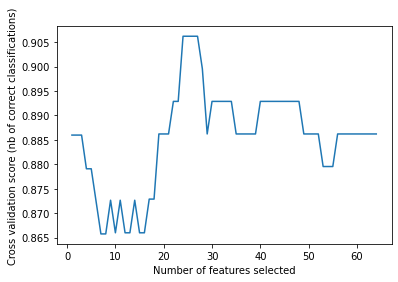

Exercising 45
1 Gender: _Male
3 What is your current occupation?_Unemployed
5 What boosts your confidence ? _By leading others to success
6 What boosts your confidence ? _Get the most/ special attention among the members
7 What boosts your confidence ? _When someone acknowledges you
8 What boosts your confidence ? _When you accomplish a project
9 I prefer to spend my money on...._Food
13 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
14 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
17 Choose a pet which you prefer to keep._Cat
20 Choose a pet which you prefer to keep._Hamster
21 Choose a pet which you prefer to keep._Horse
22 Choose a pet which you prefer to keep._I'm not a pet person


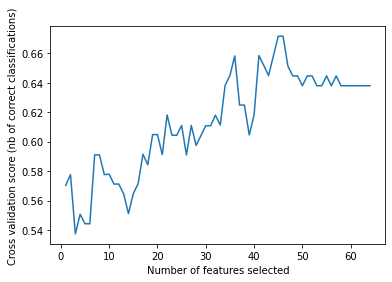

Writing 1
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar


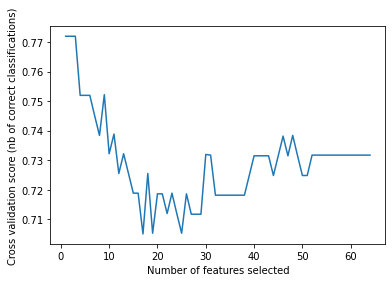

Dancing 5
10 I prefer to spend my money on...._Home Improvements
26 What is your favorite time of the day?_Evening
35 When you retire, you'd like to live..._Exactly where I live now
38 When you retire, you'd like to live..._Overseas
58 Are you a trusting person?


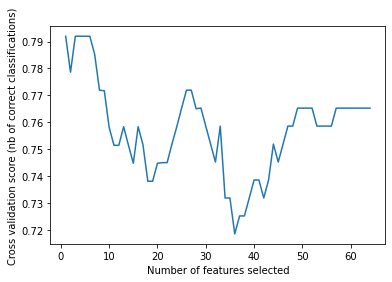

Gardening 1
59 Do you have lot of patience?


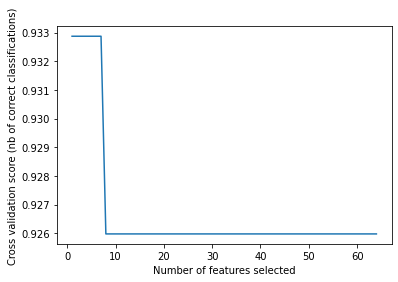

Painting 7
1 Gender: _Male
8 What boosts your confidence ? _When you accomplish a project
10 I prefer to spend my money on...._Home Improvements
22 Choose a pet which you prefer to keep._I'm not a pet person
42 What is your favorite color?_Purple
53 How creative of a person do you think you are?
54 How logical of a person do you think you are?


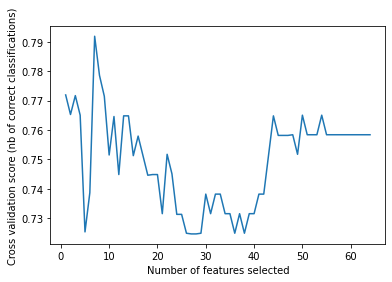

Cooking 32
1 Gender: _Male
4 What is your current occupation?_University student
6 What boosts your confidence ? _Get the most/ special attention among the members
7 What boosts your confidence ? _When someone acknowledges you
9 I prefer to spend my money on...._Food
10 I prefer to spend my money on...._Home Improvements
11 I prefer to spend my money on...._The latest fashion
12 I prefer to spend my money on...._The latest technology
13 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
19 Choose a pet which you prefer to keep._Fish
22 Choose a pet which you prefer to keep._I'm not a pet person
23 Choose a pet which you prefer to keep._Rabbit
26 What is your favorite time of the day?_Evening
27 What is your favorite time of the day?_Morning
28 What is your favorite time of the day?_Night
38 When you retire, you'd like to live..._Overseas


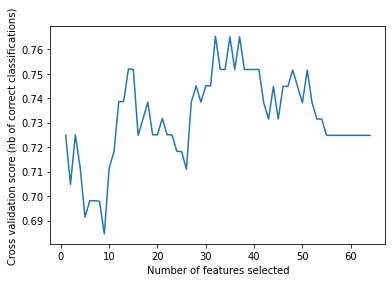

Singing 3
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
63 Can you understand others' perspectives and feelings?
64 How confident are you in your own abilities?


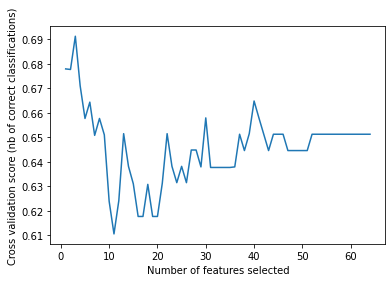

Puzzles 1
33 What do you worry more about the most?_Your family and friends


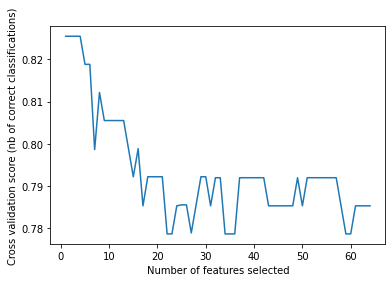

49 What is your learning style? (Pick one that benefit you the most)_By reading a physical book


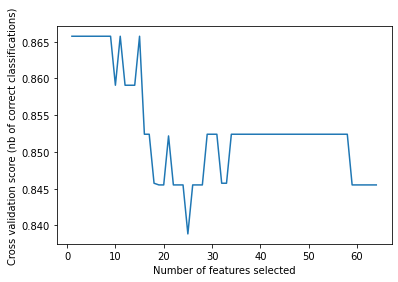

In [68]:
scoring = 'f1_micro'
min_features_to_select=1
rfecv_by_class = []

for i in range(y_train.shape[1]):
  model = LogisticRegression()
  rfecv = RFECV(model, step=1, cv=5, min_features_to_select=min_features_to_select, scoring=scoring)
  rfecv.fit(x_train, y_train[:,i])
  rfecv_by_class.append(rfecv.ranking_)
  print(y.columns[i], rfecv.n_features_) # rfecv.n_features_ shows the best number of features
  for i in range(len(x.columns)): 
    if rfecv.support_[i]:
      print(i+1, x.columns[i])

# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# selected_features = np.mean(selected_features, axis=0)
# print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation f1 score)
  plt.plot(range(min_features_to_select,
                len(rfecv.grid_scores_) + min_features_to_select),
          rfecv.grid_scores_)
  plt.show()

rfecv_by_class = np.array(rfecv_by_class)  

##### Evaluation

In [69]:
rfe_analysis = sort_by_questions(np.mean(rfecv_by_class, axis=0), x, ascending=True) 

In [70]:
params = adapt_models[("Twin_SVM", MLTSVM)]
scoring = 'f1_micro'

results = {}
for i in range(len(rfe_analysis.index)):
  best_k_features = select_best_k_features(rfe_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  y_sparse = sparse.csr_matrix(y_train)
  x_sparse = sparse.csr_matrix(x_train)
  clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_sparse, y_sparse)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.3375
Number of best k features: 2 score: 0.3375
Number of best k features: 3 score: 0.3375
Number of best k features: 4 score: 0.3375
Number of best k features: 5 score: 0.3375
Number of best k features: 6 score: 0.34285714285714286
Number of best k features: 7 score: 0.3375
Number of best k features: 8 score: 0.3375
Number of best k features: 9 score: 0.3375
Number of best k features: 10 score: 0.3375
Number of best k features: 11 score: 0.3870967741935484
Number of best k features: 12 score: 0.3501199040767386
Number of best k features: 13 score: 0.3668903803131991
Number of best k features: 14 score: 0.3721973094170404
Number of best k features: 15 score: 0.379862700228833
Number of best k features: 16 score: 0.3746958637469587
Number of best k features: 17 score: 0.3709677419354838
Number of best k features: 18 score: 0.3620689655172414
Number of best k features: 19 score: 0.358974358974359
Number of best k features: 20 score: 0.388732394366197

- Based on the result above, the best number of features is 21.

In [75]:
# the best 21 features was used to train all the algorithms
best_k_features = select_best_k_features(rfe_analysis, k=21)
x = filter_features(best_k_features, df_norm)
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
best_k_features

['Gender: ',
 "Can you understand others' perspectives and feelings?",
 'How creative of a person do you think you are?',
 'Do you enjoy making others happy?',
 'Are you a trusting person?',
 'Do you enjoy challenges?',
 'Do you have lot of patience?',
 'How logical of a person do you think you are?',
 'What is your favorite color?',
 'Would you prefer to engage your brain more than your body?',
 'Are you a perfectionist?',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'What boosts your confidence ? ',
 'Do you enjoy socializing with large groups of people?',
 'What do you worry more about the most?',
 'Would you rather visit the future or the past?',
 "When you retire, you'd like to live...",
 'What is your favorite time of the day?',
 'Do you like to sit in front of a computer for long hours?',
 'Choose a pet which you prefer to keep.',
 'How confident are you in your own abilities?']

- These 21 questions above were used to train all the algorithms.
- The results are shown below.

In [74]:
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Reading(23),Playing computer games(17),Cooking(13),Singing(11),Exercising(8),Team sports(7),Puzzles(6),Badminton(6),Playing board games(5),Dancing(4),Painting(3),Gardening(2),Writing(2),Collecting(1)
Twin_SVM,38.968481,64.000000,63.636364,52.941176,38.709677,37.500000,33.333333,38.095238,21.428571,20.000000,12.500000,30.769231,0.0,9.090909,13.333333
Classifier_Chain_Ridge,37.647059,70.833333,57.142857,12.500000,15.384615,35.294118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Binary_Relevance_MLP,37.500000,60.465116,57.142857,52.173913,42.105263,33.333333,0.000000,22.222222,0.000000,28.571429,0.000000,0.000000,0.0,0.000000,0.000000
Classifier_Chain_Decision_Tree,37.450199,71.428571,57.894737,30.000000,40.000000,46.153846,40.000000,0.000000,9.523810,15.384615,36.363636,18.181818,0.0,0.000000,0.000000
Binary_Relevance_kNN_A,37.096774,56.521739,54.545455,33.333333,55.172414,32.000000,40.000000,36.363636,0.000000,50.000000,0.000000,0.000000,0.0,14.285714,0.000000
Multi-Label_KNN,37.096774,56.521739,54.545455,33.333333,55.172414,32.000000,40.000000,36.363636,0.000000,50.000000,0.000000,0.000000,0.0,14.285714,0.000000
Binary_Relevance_Extra_Trees,36.585366,62.222222,46.666667,14.285714,42.857143,38.095238,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.0,0.000000,0.000000
Binary_Relevance_Ridge,36.464088,62.500000,62.857143,33.333333,14.285714,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Classifier_Chain_MLP,36.453202,63.829787,64.705882,20.000000,35.294118,40.000000,0.000000,20.000000,0.000000,0.000000,0.000000,33.333333,0.0,0.000000,0.000000
Binary_Relevance_Decision_Tree,36.144578,57.142857,61.111111,24.000000,44.444444,40.000000,22.222222,37.500000,10.526316,28.571429,0.000000,0.000000,0.0,50.000000,0.000000
